## H2: Particle filter for a linear Gaussian state-space model

In [1]:
import os
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def generate_data(T):
    y = np.zeros(T)
    x = np.zeros(T+1)
    x[0] = np.random.normal(loc=0.0, scale=np.sqrt(2.0) )
    for t in range(T):
        x[t+1] = np.random.normal(loc=0.8*x[t], scale=np.sqrt(0.5))
        y[t] = np.random.normal(loc=2*x[t+1], scale=np.sqrt(0.1))
    return y, x

np.random.seed(42)
T=2000
y, x = generate_data(T)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(y)
ax.set_xlabel("Time $t$"); ax.set_ylabel("Observation $y_t$");
plt.show()

<Figure size 1600x500 with 1 Axes>

In [3]:
# Implement the Kalman filter!
def kalman_filter(y, A, C, Q, R, P0):
    
    T = len(y)
    # Define filtering means x_hat and covariances P_hat
    x_hat = np.zeros(T+1)
    P_hat = np.zeros(T+1)
    
    # Initialize mean and cov at time 0 as zero and P0 respectively
    P_hat[0] = P0
    
    for t in range(1, T+1):
        
        P_time_update = A**2 * P_hat[t-1] + Q
        K = P_time_update * C / (P_time_update * C**2 + R)
        
        x_hat[t] = A*x_hat[t-1] + K*(y[t-1] - C*A*x_hat[t-1])
        P_hat[t] = P_time_update - K*C*P_time_update
        
    return x_hat, P_hat

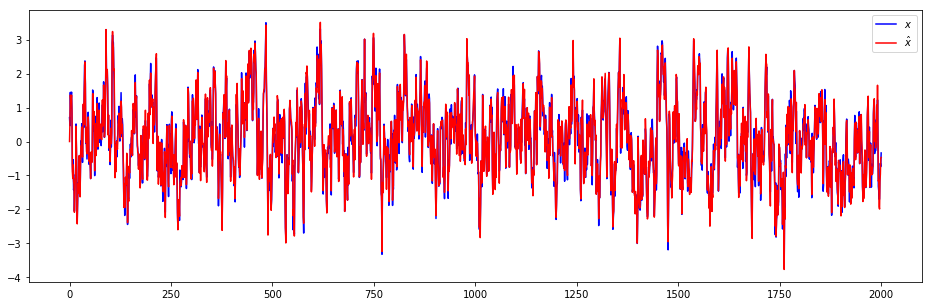

In [4]:
x_hat, P_hat = kalman_filter(y, A=0.8, C=2.0, Q=0.5, R=0.1, P0=2.0)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, 'b-', label='$x$', fillstyle='none')
ax.plot(x_hat, 'r-', label='$\hat{x}$', fillstyle='none')
#ax.set_xlim(-1, T+1)
ax.legend()
plt.show()

In [5]:
# Bootstrap particle filter
#def bootstrap_particle_filter(y, n_particles, resampling_type='multinomial', ess_thres=None):
def bootstrap_particle_filter(y, N, theta, resampling_type='multinomial'):

    # Static parameters 
    A = theta[0] # for mean of transition model
    C = theta[1] # for mean of observations
    Q = theta[2] # variance of process noise
    R = theta[3] # variance of observations
    
    # Initialization
    T = len(y)
    x = np.zeros([T+1, N])
    w = np.zeros([T+1, N])
    ancestors = np.zeros([T+1, N], dtype=int)
    
    x[0, :] = np.random.normal(0.0, 1.0, size=N)
    w[0, :] = np.ones(N) / N
    ancestors[0, :] = range(N)
    
    for t in range(1, T+1):
        
        if resampling_type == 'multinomial':
            ancestors[t, :] = multinomial_resampling(w[t-1, :])
        else:
            ancestors[t, :] = np.choice(N, N, p=w[t-1, :])
        
        x[t, :] = np.random.normal(loc=A*x[t-1, ancestors[t, :]], scale=np.sqrt(Q) )
        log_w_tilde = norm.logpdf(y[t-1], loc=C*x[t, :], scale=np.sqrt(R) )
                                  
        # Normalize with log trick
        max_w_tilde = np.max(log_w_tilde)
        log_w_tilde = log_w_tilde - max_w_tilde
        w_bar = np.exp(log_w_tilde - np.max(log_w_tilde))
        w[t, :] = w_bar / np.sum(w_bar)
    return x, w, ancestors

def multinomial_resampling(w):
    N = len(w)
    # Generate ordered uniform random numbers 
    u_sample = np.random.uniform(size=N)
    u = np.zeros(N)
    u[N-1] = u_sample[N-1]**(1/N)
    for k in range(N-1, 0, -1):
        u[k-1] = u[k] * u_sample[k-1]**(1/k) 
    
    # Generate offsprings
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors

In [22]:
# Parameters 
A=0.8; C=2.0; Q=0.5; R=0.1; P0=2.0
# Run Kalman filter
means_kf, cov_kf = kalman_filter(y, A, C, Q, R, P0)
# Run bootstrap particle filter
theta = [A, C, Q, R]
N = 100
x_bpf, w_bpf, ancestors = bootstrap_particle_filter(y, N, theta, resampling_type='multinomial')

In [23]:
# Compute BPF mean and variance
# See Eq. 13 in http://user.it.uu.se/~thosc112/pubpdf/schongk2011.pdf
means_bpf = np.sum(x_bpf * w_bpf, axis=-1)
cov_bpf = np.sum( (x_bpf - means_bpf[:,None])**2 * w_bpf, axis=-1)
adiff = np.mean(np.abs(means_kf - means_bpf))
print("Average absolute difference: ", adiff)

Average absolute difference:  0.026869163150591593


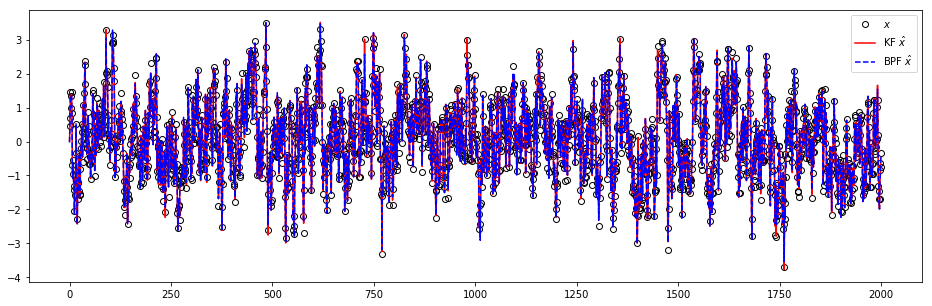

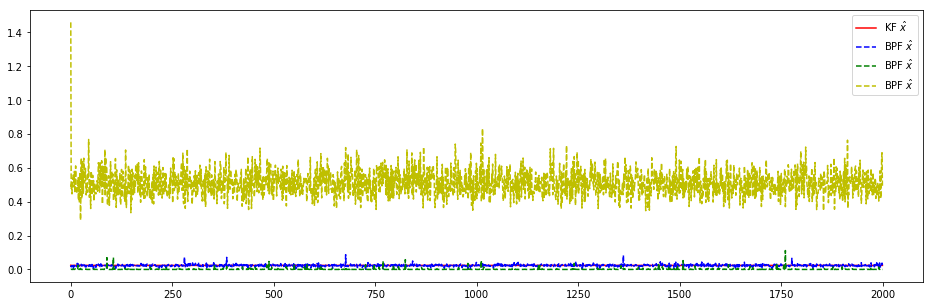

In [24]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, 'ko', label='$x$', fillstyle='none')
ax.plot(means_kf, 'r-', label='KF $\hat{x}$')
ax.plot(means_bpf, 'b--', label='BPF $\hat{x}$')
ax.legend()

fig, ax = plt.subplots(figsize=(16, 5))
#ax.plot(x, 'ko', label='$x$', fillstyle='none')
ax.plot(cov_kf[1:], 'r-', label='KF $\hat{x}$')
ax.plot(cov_bpf[1:], 'b--', label='BPF $\hat{x}$')
ax.plot(np.var(x_bpf[1:, :]*w_bpf[1:,:], axis=-1), 'g--', label='BPF $\hat{x}$')
ax.plot(np.var(x_bpf[1:, :], axis=-1), 'y--', label='BPF $\hat{x}$')
ax.legend()
plt.show()

## (d) Fully-adapted PF

In [2]:
def fully_adapted_particle_filter(y, n_particles, theta):
    # Static parameters
    A = theta[0] # for mean of transition model
    C = theta[1] # for mean of observations
    Q = theta[2] # variance of process noise
    R = theta[3] # variance of observations
    
    #sigma2_x = 1.0 # Noise variance in dynamics 
    #sigma2_y = 0.01 # Noise variance in measurements 
    #c = 2.0 
    #K = sigma2_x * c / (c**2 * sigma2_x + sigma2_y)
    
    T = len(y)
    
    # Initialization
    #x = np.random.normal(0.0, 1.0, size=n_particles)
    #w = np.ones(n_particles) / n_particles

    ancestors = np.zeros([T+1, n_particles], dtype=int)
    ancestors[0, :] = range(n_particles)
    x = np.zeros([T+1, n_particles])
    x[0, :] = np.random.normal(0.0, 1.0, size=n_particles)
    w = np.zeros([T+1, n_particles])
    w[0, :] = np.ones(n_particles) / n_particles
    
    for t in range(1, T+1):
        
        # Compute adjustment multipliers using p(y_t | x_{t-1})
        #v = norm.pdf(y[t], loc=c*np.cos(x)**2, scale=np.sqrt(c**2 * sigma2_x + sigma2_y) )
        v = norm.pdf(y[t-1], loc=A*C*x[t-1, :], scale=np.sqrt(C**2 * Q + R))
        
        # Resample x with probabilities proportional to w_{t-1}*v_{t-1} 
        resampling_weights = (w[t-1, :] * v) / np.sum(w[t-1, :] * v)
        #print(resampling_weights.shape)
        ancs = np.random.choice(n_particles, n_particles, p=resampling_weights)
        x_resampled = x[t-1, ancs]
        
        # Sample x from posterior p(x_t | x_{t-1}, y_t)
        #x = np.random.normal(loc=np.cos(x_resampled)**2 + K*(y[t] - c*np.cos(x_resampled)**2 ),
        #                     scale=np.sqrt((1 - c*K)*sigma2_x) )
        x[t, :] = np.random.normal(loc=(C*y[t-1] + A*(R/Q)*x_resampled)/(C**2 + (R/Q)),
                            scale=R/(C**2 + (R/Q)) )
        
        # Don't need to update weights, since they are w_tilde is const. -> w = 1/n_particles
        # w = omega(x_resampled, x, y) = p(y | x_resampled) / v(x_resampled, y) = 1
        
        #x[t, :] = x
        w[t, :] = w[t-1, :]
        ancestors[t, :] = ancs
    #return X, W, A
    return x, w, ancestors
    

In [52]:
T = len(y)
n_particles = [10, 50, 100, 1000, 5000]
err_bpf = np.zeros(len(n_particles))
err_fapf = np.zeros(len(n_particles))

# Run kalman filter for comparing with BPF and FAPF
means_kf, _ = kalman_filter(y, A=0.8, C=2.0, Q=0.5, R=0.1, P0=2.0)
theta = [0.8, 2.0, 0.5, 0.1]

for i, n in enumerate(n_particles):
    # Bootstrap PF
    x_bpf, w_bpf, _ = bootstrap_particle_filter(y, n, theta)
    means_bpf = np.sum(x_bpf * w_bpf, axis=-1)
    err_bpf[i] = np.mean(abs(means_kf - means_bpf))
    
    # Fully-adapted PF
    x_fapf, w_fapf, _ = fully_adapted_particle_filter(y, n, theta)
    means_fapf = np.sum(x_fapf * w_fapf, axis=-1)
    err_fapf[i] = np.mean(abs(means_kf - means_fapf))

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(err_bpf, '-o', label='Bootstrap PF')
ax.plot(err_fapf, '-o', label='Fully-adapted PF')
ax.set_xlabel("Number of particles $N$"); ax.set_ylabel("Avg. Absolute Difference")
ax.legend()
plt.xticks(np.arange(len(n_particles)), labels=[str(n) for n in n_particles])
plt.show()

KeyboardInterrupt: 

## (e) Plot trajectories for FAPF

In [3]:
def plot_trajectories(x, ancestors):
    N = x.shape[0] # number pf particles
    T = x.shape[1] - 1 # number of time steps in dataset
    
    # Get trajectories of dead particles
    dead_particles = [] # Store state/particle values 

    for t in range(1, T + 1):
        dead_ind = np.setdiff1d(range(N), ancestors[:, t]) #returns unique values in first arg that are not in arg2
        traj_of_dead_ind = np.zeros((len(dead_ind), t))
        ancestors_of_dead_ind = dead_ind
        for s in range(t, 0, -1):
            #print("s: ", s)
            ancestors_of_dead_ind = ancestors[ancestors_of_dead_ind, s - 1]
            traj_of_dead_ind[:, s - 1] = x[ancestors_of_dead_ind, s - 1]

        dead_particles.append(traj_of_dead_ind)
    
    # Get trajectories of particles that survived
    alive_particles = np.zeros((N, T + 1))
    alive_particles[:, T] = x[:, T]
    ancs_t = range(N)
    for t in range(T, 0, -1):
        ancs_t = ancestors[ancs_t, t - 1]
        alive_particles[:, t - 1] = x[ancs_t, t - 1]
        
    # plot dead and alive particles
    fig, ax = plt.subplots(figsize=(16, 5))
    
    for traj in dead_particles:
        for i in range(traj.shape[0]):
            ax.plot(traj[i, :], 'o-', linestyle='-', fillstyle='none', 
                    color='grey', markersize=3, lw=1,
                    alpha=0.5, antialiased=True);
    
    for i in range(N):
        ax.plot(alive_particles[i, :], 'o-', linestyle='-', markeredgecolor='r',
                    markerfacecolor='r',
                    color='k', markersize=4, lw=1,
                    alpha=1, antialiased=True);
    

    ax.set_xlabel('Time'); ax.set_ylabel('State $X$')
    ax.set_xlim(-1, T+1)
    plt.show()    

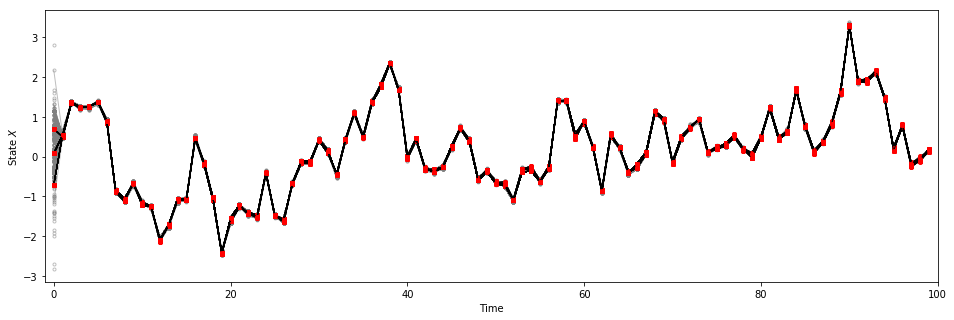

In [4]:
N = 100
theta = [0.8, 2.0, 0.5, 0.1]
x_fapf, w_fapf, ancs_fapf = fully_adapted_particle_filter(y, N, theta)
x_fapf_T = x_fapf.T
ancs_fapf_T = ancs_fapf.T
plot_trajectories(x_fapf.T[:, :100], ancs_fapf.T[:, :100])

## (e) FAPF with systematic resampling

In [15]:
def systematic_resampling(w):
    N = len(w)
    # Draw random numbers uniformly from equidistant intervals
    u = np.zeros(N)
    u[0] = np.random.uniform(0.0, 1/N)
    for i in range(1,N):
        u[i] = u[i-1] + 1/N
    #print(u)
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors

def fully_adapted_particle_filter(y, n_particles, theta, resampling_type='', ess_trigger=None):
    # Static parameters
    A = theta[0] # for mean of transition model
    C = theta[1] # for mean of observations
    Q = theta[2] # variance of process noise
    R = theta[3] # variance of observations

    # Initialization
    T = len(y)
    ancestors = np.zeros([T+1, n_particles], dtype=int)
    ancestors[0, :] = range(n_particles)
    x = np.zeros([T+1, n_particles])
    x[0, :] = np.random.normal(0.0, 1.0, size=n_particles)
    w = np.zeros([T+1, n_particles])
    w[0, :] = np.ones(n_particles) / n_particles
    N_ess_vec = np.zeros(T)
    
    for t in range(1, T+1):
        
        # Compute adjustment multipliers using p(y_t | x_{t-1})
        v = norm.pdf(y[t-1], loc=A*C*x[t-1, :], scale=np.sqrt(C**2 * Q + R))
        
        # Resample x with probabilities proportional to w_{t-1}*v_{t-1} 
        resampling_weights = (w[t-1, :] * v) / np.sum(w[t-1, :] * v)
        # Compute effective sample size (ESS)
        N_ess = 1 / np.sum(resampling_weights**2)
        N_ess_vec[t-1] = N_ess
        
        if ess_trigger is None or N_ess < ess_trigger:
            if resampling_type == 'systematic':
                ancs = systematic_resampling(resampling_weights)
        else:
            if resampling_type == 'systematic':
                ancs = systematic_resampling(resampling_weights)
            else:
                ancs = np.random.choice(n_particles, n_particles, p=resampling_weights)
            #raise ValueError("Resampling type {} is unknown.".format(resampling_type))
        #else:
            #ancestors[:, t] = ancestors[:, t-1]

        x_resampled = x[t-1, ancs]
        
        # Sample x from posterior p(x_t | x_{t-1}, y_t)
        x[t, :] = np.random.normal(loc=(C*y[t-1] + A*(R/Q)*x_resampled)/(C**2 + (R/Q)),
                            scale=R/(C**2 + (R/Q)) )
        
        # Don't need to update weights, since they are w_tilde is const. -> w = 1/n_particles
        # w = omega(x_resampled, x, y) = p(y | x_resampled) / v(x_resampled, y) = 1
        w[t, :] = w[t-1, :]
        ancestors[t, :] = ancs
    return x, w, ancestors, N_ess_vec
    

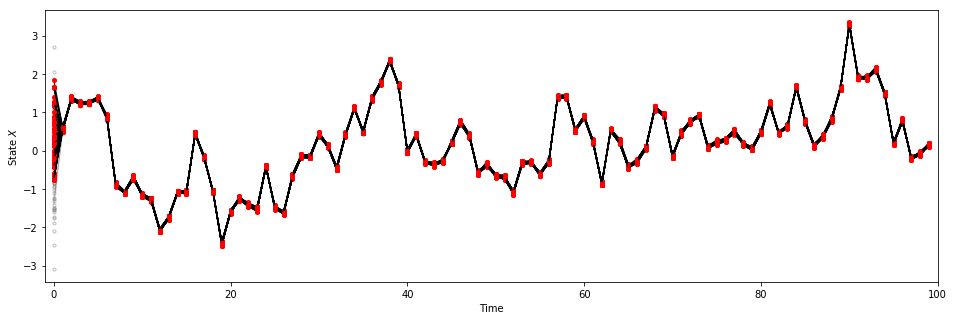

In [9]:
N = 100
theta = [0.8, 2.0, 0.5, 0.1]
x_fapf, w_fapf, ancs_fapf, _ = fully_adapted_particle_filter(y, N, theta, resampling_type='systematic')
x_fapf_T = x_fapf.T
ancs_fapf_T = ancs_fapf.T
plot_trajectories(x_fapf.T[:, :100], ancs_fapf.T[:, :100])

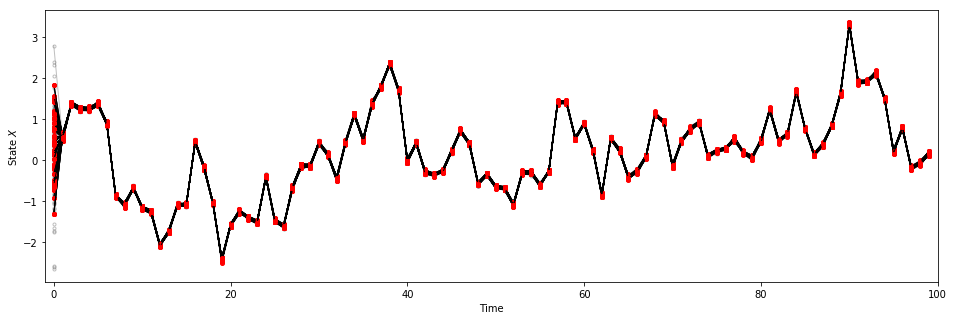

In [16]:
# ESS trigger N/2=50
N = 100
x_fapf, w_fapf, ancs_fapf, N_ess = fully_adapted_particle_filter(y, N, theta, resampling_type='systematic', ess_trigger=N/2)
x_fapf_T = x_fapf.T
ancs_fapf_T = ancs_fapf.T
plot_trajectories(x_fapf.T[:, :100], ancs_fapf.T[:, :100])

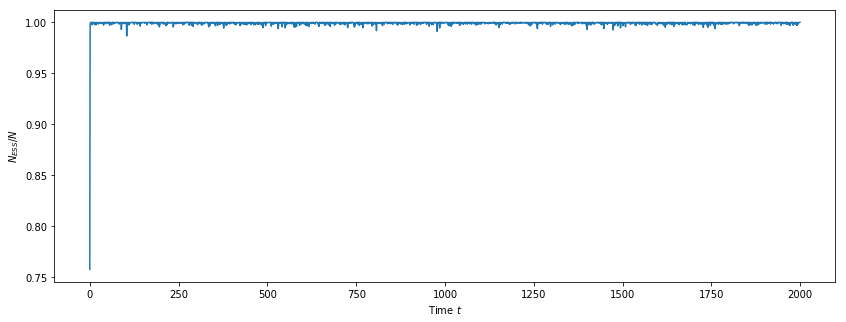

In [19]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(N_ess/N, '-')
ax.set_xlabel("Time $t$"); ax.set_ylabel("$N_{ESS}/N$")
plt.show()